# Patch NN approach

In [2]:
from bs4                     import BeautifulSoup
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg
import numpy                 as np
import dicom
import glob
import scipy.misc
import os
import json
import pylab

data_filepath = "/enc_data/eddata/pacemaker/"
ann_filepath = data_filepath + "ann/"
img_filepath = data_filepath + 'organized-data/'
png_filepath = data_filepath + 'png/'

SIZE_X = 550
SIZE_Y = 675

## Patch sizes

In [3]:
# Returns the dimensions of the box as: 
#     (x_min, x_max, y_min, y_max)
def get_box(filename): 
    with open(ann_filepath + filename, 'r') as f: 
        soup = BeautifulSoup(f, 'xml')
        
        box = soup.bndbox
        return (int(box.xmin.string), int(box.xmax.string), int(box.ymin.string), int(box.ymax.string))

print get_box('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')

(1901, 2451, 699, 1245)


In [4]:
def get_x_size(box): 
    return box[1] - box[0]

def get_y_size(box): 
    return box[3] - box[2]

def get_center(box): 
    x_center = np.mean([box[0], box[1]])
    y_center = np.mean([box[2], box[3]])
    return (x_center, y_center)

box = get_box('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
x_size = get_x_size(box)
y_size = get_y_size(box)

print x_size, y_size
print get_center(box)

550 546
(2176.0, 972.0)


1009504_6340563-2190-02-24-0927-CHEST, PORTABLE.xml 'NoneType' object has no attribute 'xmin'


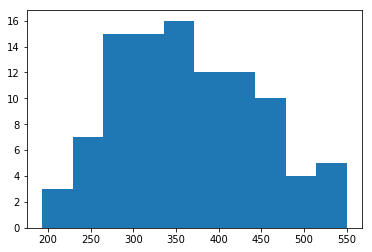

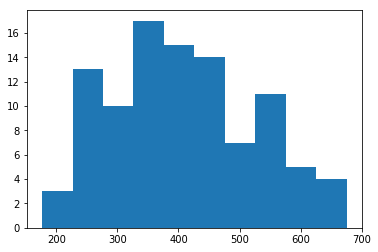

550 675


In [5]:
def get_sizes(): 
    x_sizes, y_sizes = [], []
    
    for dicom_file in os.listdir(ann_filepath): 
        if not dicom_file.endswith('.xml'): 
            continue
        
        try: 
            box = get_box(dicom_file)
            x_size = get_x_size(box)
            y_size = get_y_size(box)

            x_sizes.append(x_size)
            y_sizes.append(y_size)
            
        except Exception as e: 
            print dicom_file, e
    
    return x_sizes, y_sizes

x_sizes, y_sizes = get_sizes()
plt.hist(x_sizes)
plt.show()
plt.hist(y_sizes)
plt.show()

x_size = np.max(x_sizes)
y_size = np.max(y_sizes)

print x_size, y_size

## Visualize patches

In [6]:
# Assumes filename is given as patientid_clipnum.dcm
def get_dicom_array(filename): 
    patient_id = filename.split("_")[0]
    clipnum = filename.split("_")[1].split(".")[0] + ".dcm"
    
    dc_array = dicom.read_file(img_filepath + patient_id + "/" + clipnum).pixel_array
    return dc_array    

In [7]:
def save_image(array, filename): 
    scipy.misc.imsave(filename, array)
    
def plot_image(filename): 
    img = mpimg.imread(filename)
    plt.imshow(img, cmap=pylab.cm.bone)
    plt.show()

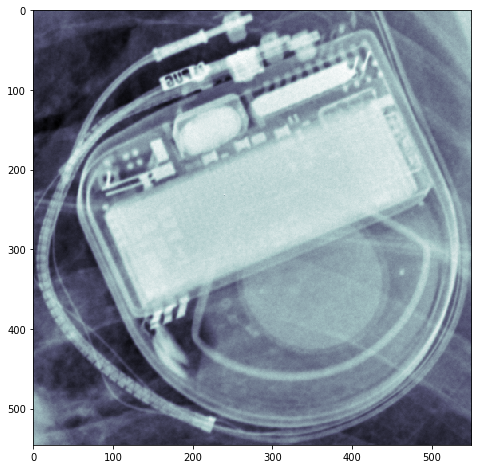

In [8]:
def get_pacemaker_array(filename, rotate=0): 
    box = get_box(filename)
    
    dc_array = get_dicom_array(filename)
    pacemaker_array = dc_array[box[2]:box[3],box[0]:box[1]]
    
    pacemaker_array = np.rot90(pacemaker_array, k=rotate)
    
    return pacemaker_array
    
pacemaker = get_pacemaker_array('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
plt.figure(figsize=[8,8])
plt.imshow(pacemaker, cmap=pylab.cm.bone)
plt.show()

In [9]:
def get_bounds(center_dim, size, max_size): 
    dim_min = center_dim - size / 2
    dim_max = center_dim + (size - size / 2)
    
    if dim_min < 0: 
        dim_min = 0
        dim_max = size
    if dim_max >= max_size: 
        dim_max = max_size - 1
        dim_min = max_size - 1 - size
    
    return int(dim_min), int(dim_max)

def get_max_box(filename): 
    box = get_box(filename)
    img_dims = get_dicom_array(filename).shape

    center = get_center(box)
    x_min, x_max = get_bounds(center[0], SIZE_X, img_dims[1])
    y_min, y_max = get_bounds(center[1], SIZE_Y, img_dims[0])
    
    return (x_min, x_max, y_min, y_max)

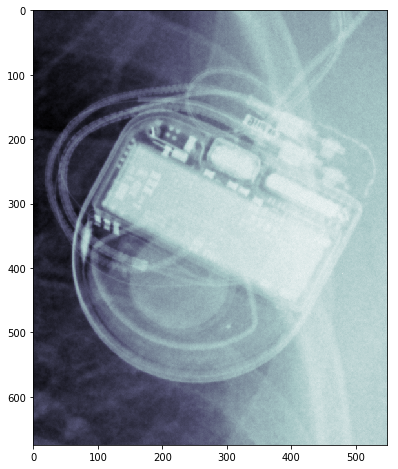

In [10]:
# Normalize to a specific size (the maximum patch size)
def get_max_pacemaker_array(filename): 
    max_box = get_max_box(filename) 
    
    dc_array = get_dicom_array(filename)
    max_pacemaker_array = dc_array[max_box[2]:max_box[3],max_box[0]:max_box[1]]
    
    return max_pacemaker_array

# pacemaker = get_max_pacemaker_array('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
pacemaker = get_max_pacemaker_array('2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.xml')
plt.figure(figsize=[8,8])
plt.imshow(pacemaker, cmap=pylab.cm.bone)
plt.show()

## Save all patches + rotated

In [71]:
# for ann_file in os.listdir(ann_filepath): 
#     if not ann_file.endswith('.xml'): 
#         continue
    
#     try: 
#         pacemaker = get_max_pacemaker_array(ann_file)

#         save_filename = png_filepath + "pacemaker/max_size/" + ann_file.split('.')[0] + ".png"
#         save_image(pacemaker, save_filename)

#     except Exception as e: 
#         print ann_file, e

1009504_6340563-2190-02-24-0927-CHEST, PORTABLE.xml 'NoneType' object has no attribute 'xmin'


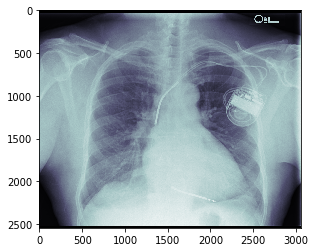

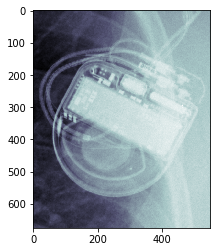

In [11]:
plot_image(png_filepath + 'full_image/2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.png')
plot_image(png_filepath + 'pacemaker/max_size/2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.png')

## Generate neg boxes

In [12]:
def get_neg_box(array): 
    dims = array.shape
    x_bound = dims[1] - SIZE_X
    y_bound = dims[0] - SIZE_Y
    
    rand_x = np.random.randint(x_bound)
    rand_y = np.random.randint(y_bound)
    
    return (rand_x, rand_x + SIZE_X, rand_y, rand_y + SIZE_Y)

In [30]:
# with open(data_filepath + "regex_ann/neg.json", 'r') as f: 
#     neg = json.load(f)
    
# i = 0
# for num in range(400): 
#     patient_id = neg[i]
    
#     for dicom_file in glob.glob(img_filepath + patient_id + "/"+ '*.dcm'): 
#         if "lateral" in dicom_file.lower(): 
#             continue
            
#         png_filename = dicom_file.lstrip(img_filepath).strip('.dcm').replace("/", '_') + ".png"
#         save_filepath = png_filepath + "neg/" + png_filename

#         dc_array = dicom.read_file(dicom_file).pixel_array
#         neg_box = get_neg_box(dc_array)
#         neg_array = dc_array[neg_box[2]:neg_box[3],neg_box[0]:neg_box[1]]
                
#         save_image(neg_array, save_filepath)
#         break
        
#     i += 1

/enc_data/eddata/pacemaker/png/


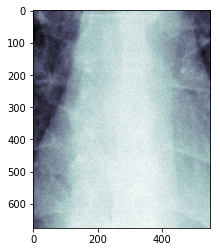

In [13]:
print png_filepath
plot_image(png_filepath + 'neg/839798_7044227-2186-04-06-1310-POSTERO-ANTERIOR.png')

## Train model

## Run on pacemaker images

In [14]:
def get_pacemaker_patch(model, pixel_array, hop_x, hop_y):
    for x in range(0, pixel_array.shape[1], hop_x): 
        for y in range(0, pixel_array.shape[0], hop_y): 
            subarray = pixel_array[y:y+SIZE_Y, x:x+SIZE_X]
            # TODO: Resize subarray to appropriate size
            
            # TODO: Run the model to see if the the subarray is classified as a pacemaker or not
            if model.is_pacemaker(subarray): 
                return (x, x+SIZE_X, y, y+SIZE_Y)

## Run on overall images

In [ ]:
true, false = [], []
for filename in os.listdir(...): 
    pixel_array = filename.pixel_array
    if contains_pacemaker(pixel_array, SIZE_X / 4, SIZE_Y / 4): 
        